In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

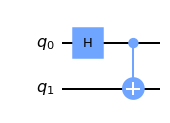

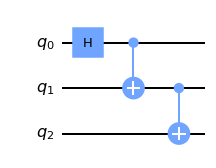

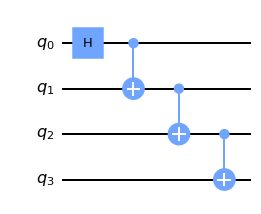

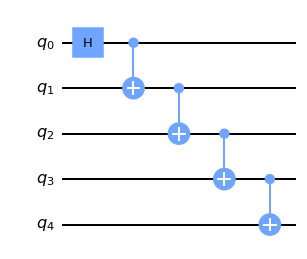

In [2]:
#Create cat states
n = 5
vectors = []
circuits = []
for i in range(2, n + 1):
    cir = QuantumCircuit(i)
    cir.h(0)
    for j in range(0, i - 1):
        cir.cx(j, j + 1)
    circuits.append(cir)
    vectors.append(qi.Statevector.from_instruction(cir))
drawings = []
for i in range(len(circuits)):
    drawings.append(circuits[i].draw(output='mpl'))

In [3]:
tomo_circuits = []
for cir in circuits:
    tomo_circuits.append(state_tomography_circuits(cir, cir.qubits));



D:\BarIlan\Qiskit\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
D:\BarIlan\Qiskit\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
D:\BarIlan\Qiskit\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
D:\BarIlan\Qiskit\lib\site-packages\qiskit\circuit\quantumcir

In [83]:
#Simulator
results = []
shots = []
name = 'ibm_lagos'
backend = provider.get_backend(name)
qubit_number = 3

noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")

circuit = tomo_circuits[qubit_number]
full_layout = [0, 1, 3, 5, 4]
i = 0
n_shots = 1
while n_shots < 8000:
    layout = full_layout[:circuit[0].num_qubits]
    store = False
    if n_shots == 2048:
        store = True

    print(n_shots)
    #results.append(utility.execute(circuit, 'ibm_lagos', str(n_shots) + " shots 5 qubit cat state" , shots=n_shots).result())
    results.append(qiskit.execute(circuit, Aer.get_backend('qasm_simulator'),
                                  coupling_map=coupling_map,
                                  basis_gates=basis_gates,
                                  noise_model=noise_model, initial_layout=layout, shots=n_shots).result())
    shots.append(i)
    i += 1
    n_shots = pow(2, i)


1
2
4
8
16
32
64
128
256
512
1024
2048
4096


In [ ]:
#Real
from qiskit.tools import job_monitor
from Tomography import utility

results = []
shots = []
backend = provider.get_backend('ibmq_jakarta')
circuit = tomo_circuits[3]
full_layout = [0, 1, 3, 5, 4]
i = 0
n_shots = 1
while n_shots < 8000:
    print(n_shots)
    #results.append(utility.execute(circuit, 'ibm_lagos', str(n_shots) + " shots 5 qubit cat state" , shots=n_shots).result())
    job = qiskit.execute(circuit, backend, initial_layout=full_layout, shots=n_shots)
    job_monitor(job)
    utility.save_job(job, "Jakarta_fidelity_to_shots_withMap_(1)")
    results.append(job.result())

    shots.append(i)
    i += 1
    n_shots = pow(2, i)


In [47]:
#Retrive results:
import utility

results = [utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)0").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)1").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)2").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)3").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)4").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)5").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)6").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)7").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)8").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)9").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)10").result(),
           utility.retrieve("Lagos_fidelity_to_shots_withMap_(1)11").result()]

Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory


In [84]:
print(results)
densities = []
fidelities = {}
purities = {}
shots = [pow(2, i) for i in range(13)]
print(shots)
for i in range(len(results)):
    tomo_fitter_bell = StateTomographyFitter(results[i], tomo_circuits[qubit_number]).fit(method='lstsq')
    densities.append(DensityMatrix(tomo_fitter_bell))
    temp_dict = {shots[i]: (pow(qi.state_fidelity(DensityMatrix(tomo_fitter_bell), vectors[qubit_number]), 2))}
    fidelities.update(temp_dict)
    temp_dict_pure = {shots[i]: (np.absolute(qi.purity(tomo_fitter_bell)))}
    purities.update(temp_dict_pure)

[Result(backend_name='qasm_simulator', backend_version='0.8.2', qobj_id='ee614f49-ec7e-4e83-8f8f-acd55ed0b345', job_id='0f8d3ae6-dfb0-4aba-bcfd-1463dc6da3c2', success=True, results=[ExperimentResult(shots=1, success=True, meas_level=2, data=ExperimentResultData(counts={'0x11': 1}), header=QobjExperimentHeader(clbit_labels=[['c3', 0], ['c3', 1], ['c3', 2], ['c3', 3], ['c3', 4]], creg_sizes=[['c3', 5]], global_phase=4.71238898038469, memory_slots=5, metadata=None, n_qubits=7, name="('X', 'X', 'X', 'X', 'X')", qreg_sizes=[['q', 7]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]]), status=DONE, seed_simulator=2642944444, metadata={'method': 'statevector', 'measure_sampling': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 5, 'applied': False}}, time_taken=0.0218208), ExperimentResult(shots=1, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1e': 1}), header=QobjExpe

fidelities: [-0.65929307 -0.09261475  0.708069  ]
purities: [-0.36619876 -0.07431967  0.72454127]


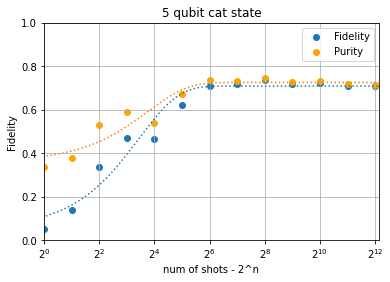

In [85]:
from scipy.optimize import minimize

plt.scatter(fidelities.keys(), fidelities.values())
plt.scatter(purities.keys(), purities.values(), color="orange")
plt.legend(["Fidelity", "Purity"])
plt.axis([1, 4500, 0, 1])
plt.xscale('log', base=2)
plt.title(str(qubit_number + 2) + ' qubit cat state')
plt.ylabel('Fidelity')
plt.xlabel('num of shots - 2^n')
plt.grid(True)
space = np.linspace(0, 4500, 9000, False)

x_data_f = np.array(list(fidelities.keys()))
y_data_f = np.array(list(fidelities.values()))

x_data_p = np.array(list(purities.keys()))
y_data_p = np.array(list(purities.values()))

exp = lambda tpl, t: tpl[2] + np.exp(tpl[1] * t) * tpl[0]
error_func = lambda tpl, t, z: sum(np.square(exp(tpl, t) - z))

tplInitial1 = (-1.,-0.1,0.6)

res_f = minimize(error_func, tplInitial1[:], args=(x_data_f, y_data_f))
res_p = minimize(error_func, tplInitial1[:], args=(x_data_p, y_data_p))
plt.plot(space, exp(tuple(res_f.x), space),":")
plt.plot(space, exp(tuple(res_p.x), space),":")

print("fidelities: " + str(res_f.x))
print("purities: " + str(res_p.x))
